# Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy

c:\ProgramData\Anaconda3\envs\snn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\Anaconda3\envs\snn\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


# Configuration

In [21]:
class config:
    input = 28*28
    output = 10
    hid = 1024    # RC Neurons
    thr = 0.5
    decay = 0.5
    rst = 0.05
    
    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    gamma = 1.0       # shape factor of gamma distribution
    binary = True    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    
    num_minibatch = 10000
    num_per_label_minibatch = 20 # number of samples of each label in one mini-batch
    batch = 128
    epoch = 10
    lr = 0.001
    l1 = 0.00015
    l1_targ = 500
    device = torch.device('cpu')
    

# Load datasets

In [22]:
# from spikingjelly.datasets.shd import SpikingHeidelbergDigits
# from spikingjelly.datasets.n_mnist import NMNIST

# nmnist_train = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=True, data_type='frame', frames_number=20, split_by='number')
# nmnist_test = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=False, data_type='frame', frames_number=20, split_by='number')
# train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

# SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=20, split_by='number')
# SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=20, split_by='number')
# train_loader = torch.utils.data.DataLoader(dataset=SHD_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset=SHD_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)


transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch, shuffle=False)

# RC Model

In [23]:
class ActFun(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - 0) < 0.5 # lens
        return grad_input * temp.float()

act_fun = ActFun.apply

def mem_update(input, mem, spk, thr, decay, rst):
    mem = rst * spk + mem * decay * (1-spk) + input
    spike = act_fun(mem - thr)
    return mem, spike

In [24]:
class RC(nn.Module):
    def __init__(self) -> None:
        super(RC, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        self.conv_in = nn.Sequential(
                                    nn.Conv2d(1, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Conv2d(16, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Flatten(),
                                    self.fc_in,
                                    )
        self.fc_in.requires_grad_ = False
        self.conv_in.requires_grad_ = False
        
        # self.A = nn.Parameter(torch.tensor(A_cluster(config)), requires_grad=False) # adjacency matrix
        self.A = nn.Linear(config.hid, config.hid, bias=False) # random initialized adjacency matrix
        nn.init.uniform_(self.A.weight, a=0, b=1)
        self.fc_out = nn.Linear(hid, out)
        
        self.thr = nn.Parameter(torch.rand(config.hid)*config.thr, requires_grad=False)
        self.decay = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=False)
        self.rst = nn.Parameter(torch.rand(config.hid)*config.rst, requires_grad=False)
        
        for name, p in self.named_parameters():
            if 'conv' in name or 'fc_in' in name:
                p.requires_grad = False
        
    def forward(self, input, device='cuda'):
        batch = input.shape[0]
        time_step = 10
        input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        sum_spk = torch.zeros(batch, config.hid).to(device)
        
        for t in range(time_step):
            x = input > torch.rand(input.size()).to(device)
            x = self.fc_in(x.float())
            # x = self.conv_in(x.float())
            # x = self.fc_in(input[:,t,:])
            # x = self.conv_in(input[:, t, :, :, :])
            
            # x = x @ self.A
            x = F.sigmoid(self.A(x))
            
            hid_mem_tmp, hid_spk_tmp = mem_update(x, hid_mem[:,t,:], hid_spk[:,t,:], self.thr, self.decay, self.rst)
            hid_mem[:,t+1,:] = hid_mem_tmp
            hid_spk[:,t+1,:] = hid_spk_tmp
            sum_spk += hid_spk_tmp
        
        sum_spk /= time_step
        out = self.fc_out(sum_spk)
        A_norm = torch.norm(self.A.weight, p=1)
        return out, hid_mem, hid_spk, A_norm


# Training pipeline

In [25]:
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader, device):
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        now = time.time()
        correct, total = 0, 0
        for i, (samples, labels) in enumerate(tqdm(train_loader)):
            # samples = samples.requires_grad_().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs, _, _, A_norm = model(samples.to(device), device)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels.long().cpu()).sum()
            
            loss = criterion(outputs, labels) + config.l1*F.relu(A_norm-config.l1_targ) # , torch.max(A_norm-6000, 0) 规定一个区间，
            loss.backward()
            optimizer.step()
        tr_acc = 100. * correct.numpy() / total
        ts_acc = test(model, test_loader, device)
        train_accs.append(tr_acc)
        test_accs.append(ts_acc)
        res_str = 'epoch: ' + str(epoch) \
                    + ' Loss: ' + str(loss.item())      \
                    + '. Tr Acc: ' + str(tr_acc)        \
                    + '. Ts Acc: ' + str(ts_acc)        \
                    + '. Time:' + str(time.time()-now)  \
                    + '. A norm:' + str(A_norm.item())
        print(res_str)
    return train_accs, test_accs

def test(model, dataloader, device='cuda'):
    correct, total = 0, 0
    for images, labels in dataloader:
        outputs, _, _, _ = model(images.to(device), device=device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.long().cpu()).sum()
    accuracy = 100. * correct.numpy() / total
    return accuracy

In [26]:
def inference(data_set, model):
    img = torch.zeros(len(data_set), 28, 28)
    for i, (d,l) in enumerate(data_set):
        img[i] = d[0]
    
    labels = np.array([d[1] for d in data_set])
    idx_per_label = [np.where(labels==i)[0] for i in range(config.output)]
    # generate mini batch
    for i in range(config.num_minibatch):
        batch_idx, batch_labels = [], []
        for j in range(config.output):
            batch_idx.extend(np.random.choice(idx_per_label[j], config.num_per_label_minibatch).tolist())
            batch_labels.extend([j]*config.num_per_label_minibatch)
        batch_data = img[batch_idx]
        batch_labels = torch.tensor(batch_labels)
        
        # print(i, batch_data.shape, batch_labels)
        out, hid_mem, hid_spk = model(batch_data.to('cuda'))
        _, predicted = torch.max(out.data, 1)
        acc = (predicted.cpu() == batch_labels.long().cpu()).sum()/config.num_per_label_minibatch/config.output
        print(hid_mem.shape, hid_spk.shape, acc)

# inference(test_dataset, model)

In [27]:
model = RC().to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, 'cpu')
accuracy = test(model, test_loader)

100%|██████████| 469/469 [02:34<00:00,  3.03it/s]


epoch: 0 Loss: 24.023822784423828. Tr Acc: 76.70166666666667. Ts Acc: 88.95. Time:168.65959358215332. A norm:157641.625


100%|██████████| 469/469 [02:44<00:00,  2.85it/s]


epoch: 1 Loss: 1.8731070756912231. Tr Acc: 88.83166666666666. Ts Acc: 89.9. Time:172.95016813278198. A norm:10088.42578125


100%|██████████| 469/469 [03:08<00:00,  2.49it/s]


epoch: 2 Loss: 0.5360157489776611. Tr Acc: 87.83166666666666. Ts Acc: 88.87. Time:199.64584231376648. A norm:1458.50927734375


100%|██████████| 469/469 [03:13<00:00,  2.42it/s]


epoch: 3 Loss: 0.5592146515846252. Tr Acc: 88.37166666666667. Ts Acc: 89.84. Time:205.43886947631836. A norm:1055.7274169921875


  5%|▌         | 25/469 [00:10<03:13,  2.29it/s]


KeyboardInterrupt: 

In [156]:
# 1-(model.A.weight.abs()<8.5e-3).sum()/65536
(model.A.weight.abs()<=10e-3).sum()

tensor(63332, device='cuda:0')

In [157]:
RC_model = deepcopy(model)
with torch.no_grad():
    baseline = 10e-3
    RC_model.A.weight[RC_model.A.weight.abs() <= baseline] = 0
    # RC_model.A.weight[RC_model.A.weight.abs() > baseline] = 1.0
    print(test(RC_model, test_loader), (RC_model.A.weight==0).sum())

89.92 tensor(63332, device='cuda:0')


In [158]:
A = RC_model.A.weight.cpu().data.numpy()
x, y = np.where(A>baseline)
x_index = y_index = [0]*config.hid
for xx, yy in zip(x, y):
    x_index[xx] += 1
    y_index[yy] += 1
x_important = np.where(np.array(x_index)>40)[0]
y_important = np.where(np.array(y_index)>40)[0]
node_important = [0]*config.hid
for i in range(256):
    if x_index[i]>=40 and y_index[i]>=40:
        node_important[i] += 1
node_important = np.where(np.array(node_important)>=1)[0]

In [141]:
RC_model.thr += torch.rand(config.hid).to('cuda')*0.001
test(RC_model, test_loader)

90.27

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 256 (seed=266230, Thu Jun  8 12:11:51 2023)
0 -90.35
0 -90.22
0 -90.1
0 -90.03
0 -90.15
0 -90.25
0 -90.13
0 -90.04
0 -89.97
0 -90.19
1 -89.99
1 -89.99
1 -90.06
1 -90.13
1 -90.06
1 -90.18
1 -90.09
1 -90.19
1 -90.18
1 -90.05
2 -90.16
2 -90.25
2 -90.15
2 -90.14
2 -90.26
2 -90.0
2 -90.18
2 -90.15
2 -90.22
2 -90.12
3 -90.1
3 -90.22
3 -90.14
3 -90.17
3 -90.06
3 -90.11
3 -89.94
3 -90.1
3 -90.11
3 -90.24
4 -90.03
4 -90.17
4 -90.23
4 -90.1
4 -90.27
4 -90.1
4 -90.05
4 -90.0
4 -90.16
4 -90.09
5 -90.11
5 -90.14
5 -90.13
5 -89.93
5 -90.07
5 -90.13
5 -89.98
5 -90.1
5 -90.17
5 -90.14
6 -89.97
6 -90.2
6 -90.18
6 -90.2
6 -90.08
6 -89.9
6 -90.24
6 -90.27
6 -90.11
6 -89.99
7 -89.95
7 -90.1
7 -89.98
7 -90.2
7 -90.05
7 -90.19
7 -90.09
7 -90.02
7 -89.97
7 -90.07
8 -90.02
8 -90.15
8 -90.06
8 -90.15
8 -90.03
8 -90.07
8 -90.18
8 -90.02
8 -90.04
8 -90.14
9 -90.07
9 -90.12
9 -89.99
9 -90.18
9 -90.16
9 -90.03
9 -90.13
9 -90.2
9 -90.05
9 -90.15
10 -90.12
10 -90.13
1

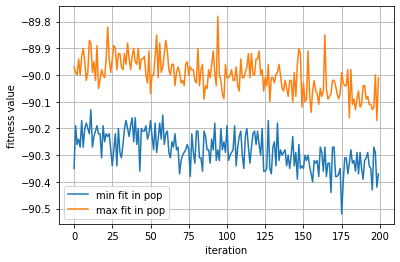

In [163]:
import cma

def fitness(x):
    tmp_model = deepcopy(RC_model)
    tmp_model.to('cpu')
    tmp_model.thr += torch.tensor(x)*0.01
    return -test(tmp_model, test_loader, device='cpu')

es = cma.CMAEvolutionStrategy(x0=[0.1]*256,
                                sigma0=0.1,
                                inopts={'popsize': 10}
                                )

log = []
for iteration in range(200):
    solutions = es.ask()
    fit = []
    for solution in solutions:
        fit_tmp = fitness(solution)
        fit.append(fit_tmp)
        print(iteration, fit_tmp)
        
    log.append([min(fit), max(fit)])
    es.tell(solutions, fit)

print('best solution\n', solutions[np.argmin(fit)])

log = np.array(log)
plt.plot(log[:,0])
plt.plot(log[:,1])
plt.grid()
plt.xlabel('iteration')
plt.ylabel('fitness value')
plt.legend(['min fit in pop', 'max fit in pop'])
plt.show()

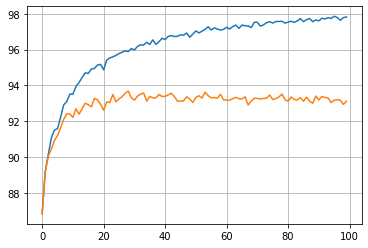

In [115]:
with open('./log/log.txt', 'r') as f:
    data = f.readlines()
test_acc = []
for d in data:
    test_acc.append(float(d.split('Ts Acc: ')[1].split('. ')[0]))
plt.plot(acc[0])
plt.plot(test_acc)
plt.grid()

In [6]:
model = RC().to('cuda')
# model.conv_in.requires_grad_ = False
for name, p in model.named_parameters():
    if 'conv' in name or 'fc_in' in name:
        p.requires_grad = False
        # print(name, p.shape)
    # if p.requires_grad is False:
    #     print(p.shape)
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 5.14K


In [17]:
model = RC()
non_zero, per_node = [], []
for i in range(256):
    model.A[i,:] = 0
    model.A[:,i] = 0
    # print(i, (model.A!=0).sum(), (model.A!=0).sum()/256)
    non_zero.append((model.A!=0).sum().item())
    per_node.append((model.A!=0).sum().item()/256)

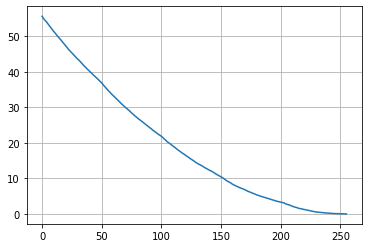

In [20]:
plt.plot(per_node)
plt.grid()

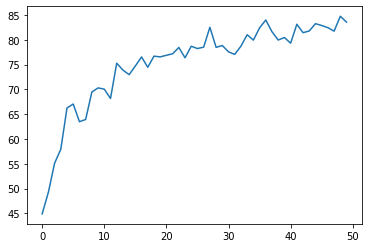

In [57]:
plt.plot(acc)

In [6]:
from thop import profile

model = RC().to('cuda')
model.conv_in.requires_grad_ = False
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

input = torch.randn(1, 20, 2, 34, 34).cuda() #.to(config.device)
flops, params = profile(model.cuda(), inputs=(input,))
print("FLOPS: {:.2f}M".format(flops / 1e6))
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 208.72K
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPS: 31.09M
Parameters: 409.68K
